In [1]:
import pandas as pd
import numpy as np
import glob
 
import os
import zipfile

import tensorflow as tf

from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# 다운로드 받은 이미지 압축 파일 해제
# print(os.listdir("./drive/MyDrive"))
local_zip = './train.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./res/train')
zip_ref.close()

local_zip = './test.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./res/test')
zip_ref.close()

In [3]:
base_dir = "./res/"

train_dir = "train/train/"

train_class = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']


test_dir = "test/test/0"

## EDA

1. 각 클래스별 데이터 불균형 정도 확인

In [4]:
for i in train_class:
    print("# of images of", i, "is", len(os.listdir(base_dir + train_dir + i)))

# of images of dog is 329
# of images of elephant is 205
# of images of giraffe is 235
# of images of guitar is 134
# of images of horse is 151
# of images of house is 245
# of images of person is 399


In [5]:
train_label = []
for path in range(len(train_class)):
    class2label = [''] + [0]
    
    for img in os.listdir(base_dir + train_dir + train_class[path]):
        class2label[0] = (train_dir + train_class[path] + "/" + img)[6:]
        if train_class[path] == "dog":
            class2label[1] = 0
        if train_class[path] == "elephant":
            class2label[1] = 1
        if train_class[path] == "giraffe":
            class2label[1] = 2
        if train_class[path] == "guitar":
            class2label[1] = 3
        if train_class[path] == "horse":
            class2label[1] = 4
        if train_class[path] == "house":
            class2label[1] = 5
        if train_class[path] == "person":
            class2label[1] = 6

        train_label.append(class2label)

train_answer = pd.DataFrame(train_label, columns = ["path", "label"])
train_answer.to_csv('./train_answer.csv', index=False)
data = pd.read_csv("./train_answer.csv")
data['label'] = data['label'].astype(str)


datagen=ImageDataGenerator(
      rescale = 1./255.,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

# train, val = train_test_split(data, test_size=0.3, random_state=42)
train_all, test = train_test_split(data, test_size=0.1, random_state=42)
train, val = train_test_split(train_all, test_size=0.2, random_state=42)
train_generator=datagen.flow_from_dataframe(
                                            dataframe=train,
                                            directory='./res/train/',
                                            x_col="path",
                                            y_col="label",
                                            batch_size=32,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(227,227))

test_generator=datagen.flow_from_dataframe(
                                            dataframe=test,
                                            directory='./res/train/',
                                            x_col="path",
                                            y_col="label",
                                            batch_size=32,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(227,227))

val_generator=datagen.flow_from_dataframe(
                                            dataframe=val,
                                            directory='./res/train/',
                                            x_col="path",
                                            y_col="label",
                                            batch_size=32,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(227,227))



Found 1222 validated image filenames belonging to 7 classes.
Found 170 validated image filenames belonging to 7 classes.
Found 306 validated image filenames belonging to 7 classes.


In [6]:
model = Sequential()
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(227,227,3)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(7,activation='softmax'))
 
model.compile(loss='categorical_crossentropy',optimizer = Adam(learning_rate=0.001),metrics=['accuracy'])

In [7]:
train_steps = train_generator.n//train_generator.batch_size
validation_steps = val_generator.n//val_generator.batch_size
# 작은 데이터의 경우에는 fit을 사용해도 무방하지만 큰 데이터라면 fit_generator를 사용하여 대용량의 데이터를 효율적으로 학습하기에 좋다.

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)


history = model.fit(train_generator,steps_per_epoch=train_steps, 
                    epochs=20, validation_data=val_generator,
                    validation_steps=validation_steps,
                    callbacks=[es,mc])

Epoch 1/20
38/38 [==============================] - 30s 577ms/step - loss: 0.1834 - accuracy: 0.9504 - val_loss: 4.4965 - val_accuracy: 0.5660
Epoch 2/20
38/38 [==============================] - 16s 423ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 2.8234 - val_accuracy: 0.5729
Epoch 3/20
38/38 [==============================] - 15s 408ms/step - loss: 0.0210 - accuracy: 0.9941 - val_loss: 10.2379 - val_accuracy: 0.1701
Epoch 4/20
38/38 [==============================] - 16s 410ms/step - loss: 0.0304 - accuracy: 0.9908 - val_loss: 2.4629 - val_accuracy: 0.6458
Epoch 5/20
38/38 [==============================] - 16s 417ms/step - loss: 0.0124 - accuracy: 0.9984 - val_loss: 0.7508 - val_accuracy: 0.7604
Epoch 6/20
38/38 [==============================] - 16s 416ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.1324 - val_accuracy: 0.9340
Epoch 7/20
38/38 [==============================] - 16s 421ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0319 - val_accuracy: 0.996

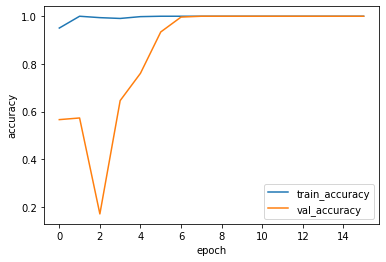

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

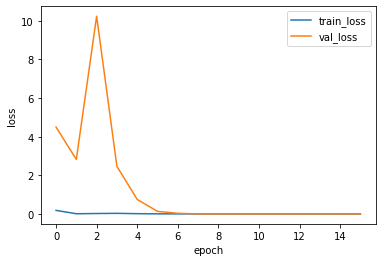

In [9]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [10]:
best_model = load_model('best_model.h5')

scores = best_model.evaluate(test_generator)
print(scores)


6/6 [==============================] - 4s 738ms/step - loss: 1.7413e-04 - accuracy: 1.0000
[0.00017412877059541643, 1.0]


In [11]:
test_df = pd.DataFrame()
test = glob.glob("./res/test/test/0/*.jpg")
test_dir = []
for img in test:
    test_dir.append(img[11:])
test_df["path"] = test_dir
 
test_datagen=ImageDataGenerator(rescale = 1./255.)
real_generator = test_datagen.flow_from_dataframe(  dataframe=test_df[:],
                                                    directory='./res/test/',
                                                    x_col="path",
                                                    y_col="path",
                                                    batch_size=1,
                                                    shuffle=False,
                                                    class_mode="raw",
                                                    target_size=(227,227))

Found 350 validated image filenames.


In [12]:
STEP_SIZE_TEST=real_generator.n//real_generator.batch_size
real_generator.reset()

In [13]:
pred = best_model.predict(real_generator,steps=STEP_SIZE_TEST,verbose=1)

pred = np.array([y.argmax() for y in pred])

filenames=real_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":pred})

350/350 [==============================] - 4s 4ms/step


In [14]:
results

,Filename,Predictions
0,test/0/0130.jpg,4
1,test/0/0162.jpg,2
2,test/0/0258.jpg,5
3,test/0/0027.jpg,6
4,test/0/0043.jpg,2
...,...,...
345,test/0/0330.jpg,2
346,test/0/0205.jpg,2
347,test/0/0033.jpg,1
348,test/0/0098.jpg,1


In [15]:
test_df = pd.read_csv("./test_answer_sample_.csv")
test_df.iloc[:,1] = results["Predictions"]
test_df.to_csv('cnn.csv', index=False)